# Homework 1: Classifiers


# Linear Softmax Classifier

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Load and preprocess CIFAR-10 dataset

In [2]:
from keras.datasets import cifar10

def get_CIFAR10_data(num_training=49000, num_validation=1000,
                     num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    # All the data comes in the uint8 format, so we need to convert
    # it to floats so that we compute numbers greater than 255.
    X_train = X_train.astype(np.float)
    X_test = X_test.astype(np.float)
    # Also, for convenience we flatten the class arrays.
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # Split the data into train, val, and test sets. In addition we will
    # create a small development set as a subset of the training data;
    # we can use this for development so our code runs faster.
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    # Our training set will be the first num_train points from the original
    # training set.
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # We will also make a development set, which is a small subset of
    # the training set.
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # We use the first num_test points of the original test set as our
    # test set.
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # third: append the bias dimension of ones (i.e. bias trick) so that our SVM
    # only has to worry about optimizing a single weight matrix W.
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Using TensorFlow backend.


Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Define a naive Softmax classifier loss function

Next we define the Softmax loss function.  This will be a naive implementation using loops.  Most of the code for this loss function already exists, but you will need to write code of your own to finish it.  Follow the instructions in the TODO section.

Recall that the contribution of a training point $(x_i, y_i)$ to the Softmax loss function is

$$L_i = -\log \left( \frac{\exp(s_{y_i})}{\sum_{j} \exp(s_j)} \right)$$

This is the cross-entropy between the predicted class probabilities, and the distribution with all probability concentrated at $y_i$.  The score $s$ is again parametrized by a linear function $s_j = xW_j$ where $x$ is a single data sample and $W_j$ is the $j$th column of $W$.

In [0]:
def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
        that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    N = X.shape[0]
    C = W.shape[1]
  
    for i in range(N):
        predictions = X[i].dot(W)
        # http://cs231n.github.io/linear-classify/#softmax
        shift_scores = predictions  - np.max(predictions) # this is so that we avoid number overflow with large numbers
        # before simplifying: - np.log(np.exp(shift_scores[y[i]])) + np.log(np.sum(np.exp(shift_scores)))
        loss_i = - shift_scores[y[i]] + np.log(np.sum(np.exp(shift_scores)))
        loss += loss_i
        for j in range(C):
            softmax_output = np.exp(shift_scores[j])/ np.sum(np.exp(shift_scores)) 
            if j == y[i]:
                dW[:,j] += (-1 + softmax_output) * X[i].T 
            else:
                dW[:,j] += softmax_output * X[i]
    loss /= N
    loss += 0.5 * reg * np.sum( W * W )
    dW = dW/N + reg * W
    #############################################################################
    #                                                    END OF YOUR CODE       #
    #############################################################################

    return loss, dW

In [22]:
# Evaluate the naive implementation of the loss we provided for you:
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.338894
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.

**Your answer:** *When randomly assigned, the chance of predicting the correct label is $\frac{1}{N} = 0.1$*


In [23]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([np.random.randint(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))
    
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.486768 analytic: 2.486768, relative error: 2.811273e-08
numerical: 0.404401 analytic: 0.404401, relative error: 1.540451e-07
numerical: -0.272207 analytic: -0.272207, relative error: 1.932183e-08
numerical: 0.637583 analytic: 0.637583, relative error: 5.803165e-08
numerical: 0.888231 analytic: 0.888231, relative error: 1.578729e-08
numerical: 0.849247 analytic: 0.849247, relative error: 6.063271e-08
numerical: -0.646503 analytic: -0.646503, relative error: 1.932111e-08
numerical: -0.245525 analytic: -0.245525, relative error: 1.123638e-07
numerical: 0.444421 analytic: 0.444421, relative error: 7.746457e-08
numerical: -2.648947 analytic: -2.648947, relative error: 1.150285e-08
numerical: 2.946625 analytic: 2.946625, relative error: 1.142355e-08
numerical: 2.533303 analytic: 2.533303, relative error: 1.391059e-08
numerical: -0.583699 analytic: -0.583700, relative error: 1.336934e-07
numerical: -1.777149 analytic: -1.777149, relative error: 4.517478e-09
numerical: -0.071806 a

## Define a vectorized Softmax classifier loss function

Next we define the vectorized (i.e. no loops) version of the Softmax loss function.  Most of the code for this loss function already exists, but you will need to write code of your own to finish it.  Follow the instructions in the TODO section.

In [0]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.
    Inputs:
      - W: A numpy array of shape (D, C) containing weights.
      - X: A numpy array of shape (N, D) containing a minibatch of data.
      - y: A numpy array of shape (N,) containing training labels; y[i] = c means
          that X[i] has label c, where 0 <= c < C.
      - reg: (float) regularization strength

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    N = X.shape[0]
    C = W.shape[1]
    
    scores = X.dot(W)
    scores_shifted = scores - np.max(scores, axis=1)[:, np.newaxis]
    scores_shifted = np.exp(scores_shifted)
    scores_shifted = scores_shifted/np.sum(scores_shifted, axis=1)[:, np.newaxis] # (N, C)
    loss = np.mean(-np.log(scores_shifted[np.arange(N), y])) + 0.5 * reg * np.sum( W * W )
    
    scores_shifted[np.arange(N), y] -= 1
    dW = X.T.dot(scores_shifted)/N + reg * W
    #############################################################################
    #                                                    END OF YOUR CODE       #
    #############################################################################

    return loss, dW

In [49]:
# Evaluate the naive implementation of the Softmax gradients

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.338894e+00 computed in 0.218840s
vectorized loss: 2.338894e+00 computed in 0.010896s
Loss difference: 0.000000
Gradient difference: 0.000000


## Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Follow the instructions in the TODO sections below.  You may just want to copy the code you wrote for the SVM.

In [0]:
class Softmax(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
                        batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
            training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
            means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #                                                                      #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.               #
            #########################################################################
            batch_indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            #########################################################################
            #                                             END OF YOUR CODE          #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            self.W -= learning_rate * grad
            #########################################################################
            #                                             END OF YOUR CODE          #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
            training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
            array of length N, and each element is an integer giving the predicted
            class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        y_pred = np.argmax(X.dot(self.W), axis=1)
        ###########################################################################
        #                                                     END OF YOUR CODE    #
        ###########################################################################
        return y_pred
    
    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
            data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [53]:
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 394.424965
iteration 100 / 1500: loss 237.758080
iteration 200 / 1500: loss 144.623902
iteration 300 / 1500: loss 88.235126
iteration 400 / 1500: loss 54.174305
iteration 500 / 1500: loss 33.517193
iteration 600 / 1500: loss 21.047487
iteration 700 / 1500: loss 13.674594
iteration 800 / 1500: loss 8.951198
iteration 900 / 1500: loss 6.281711
iteration 1000 / 1500: loss 4.522940
iteration 1100 / 1500: loss 3.584903
iteration 1200 / 1500: loss 2.976872
iteration 1300 / 1500: loss 2.576789
iteration 1400 / 1500: loss 2.328329
That took 11.366863s


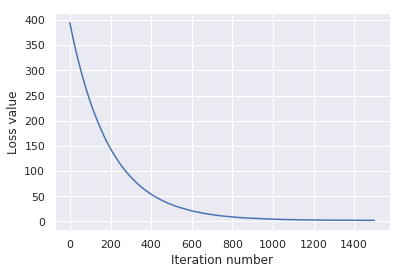

In [54]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [59]:
from itertools import product
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for l_rate, reg_strength in product(learning_rates, regularization_strengths):
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=l_rate, reg=reg_strength, num_iters=1500)
    train_accuracy = np.mean(y_train == softmax.predict(X_train))
    val_accuracy = np.mean(y_val == softmax.predict(X_val))
    
    results[(l_rate,reg_strength)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_softmax = softmax           
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.351592 val accuracy: 0.368000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.324714 val accuracy: 0.343000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.352490 val accuracy: 0.375000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.317286 val accuracy: 0.327000
best validation accuracy achieved during cross-validation: 0.375000


In [60]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.359000


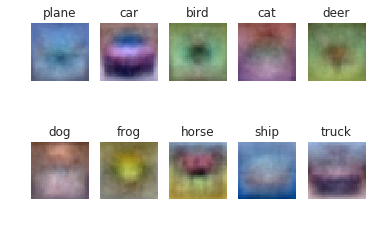

In [62]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

*Many thanks to Stanford CS231n for permission to use their materials!*